In [ ]:
from ml_core import *

# list of stored keys of loss functions
lst = [
    'dynamic_subgraph',
    'static_subgraph',
    'dynamic_weight',
    'static_weight',
    'top_10',
    'mse',
    ]

# names used in plots
indeces_keys = {
    'dynamic_subgraph': 'Dynamic subgraphing', 'static_subgraph':'Static subgraphing',
    'dynamic_weight': 'Dynamic weighting', 'static_weight': 'Static weighting',
    'top_10': 'Maximal loss', 'mse': r'$l_2$ loss'
    }

# now extract the meta data
data = []
for exp_num in range(1, 9):
    data.append([])
    for file_name in lst:
        for loss in ['combined', 'gnn']:
            with open(os.path.join('res', f'params_{file_name}_{exp_num}_{loss}.pkl'), 'rb') as f:
                data[-1].append(pickle.load(f))

In [ ]:
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as ticker

# Marker mapping for each model_type
marker_mapping = {
    'dynamic_subgraph': 'o',
    'static_subgraph': 's',
    'dynamic_weight': 'D',
    'static_weight': '^',
    'top_1': 'v',
    'top_10': '<',
    'mse': '>'
}

# Colors for each model_type
colors = {
    'combined': 'b',
    'dae': 'r',
    'gnn': 'g',
}

def plot(model_type):
    fig, axes = plt.subplots(4, 2, figsize=(10, 14))
    axes = axes.flatten()  # Convert 2x2 matrix of axes into a flat list

    for i, ax in enumerate(axes):
        df = pd.DataFrame(data[i])
        for _, row in df.iterrows():
            if row['model_type'] != model_type or row['loss_type'] == 'top_1': continue

            ax.plot(row['mse_valid'],
                    label=indeces_keys[row['loss_type']],
                    # marker=marker_mapping[row['loss_type']],
                    # color=colors[row['model_type']]
                    )
            if i in [6, 7]:
                ax.set_xlabel('Epoch')

            if i in [0, 2, 4, 6]:
                ax.set_ylabel('Validation error')

            ax.set_title(f"#Message passings: {row['num_message_passings']} | CR:{row['compression_ratio']}")
            # ax.grid(True)
            if i == 2:
                handles, labels = ax.get_legend_handles_labels()
                ax.figure.legend(handles, labels, bbox_to_anchor=(0.97, 0.97))

            ax.set_yscale('log')
            ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=10))
            ax.set_ylim(2*1e-2, 2e1)
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.tight_layout()
    plt.savefig(model_type+".pdf", format="pdf")
    plt.show()


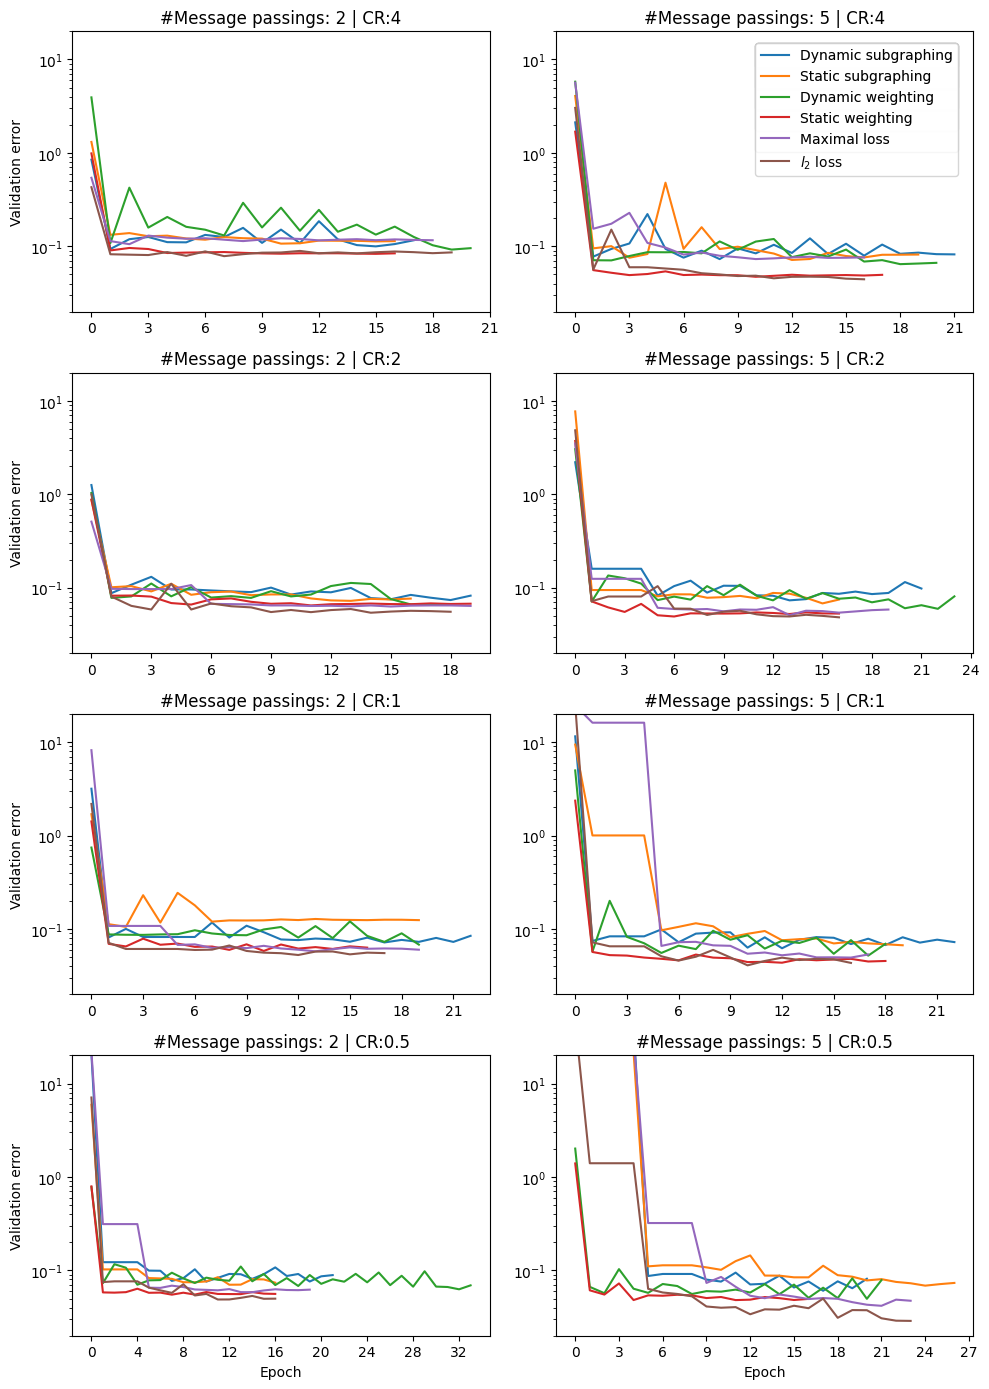

In [ ]:
plot('combined')

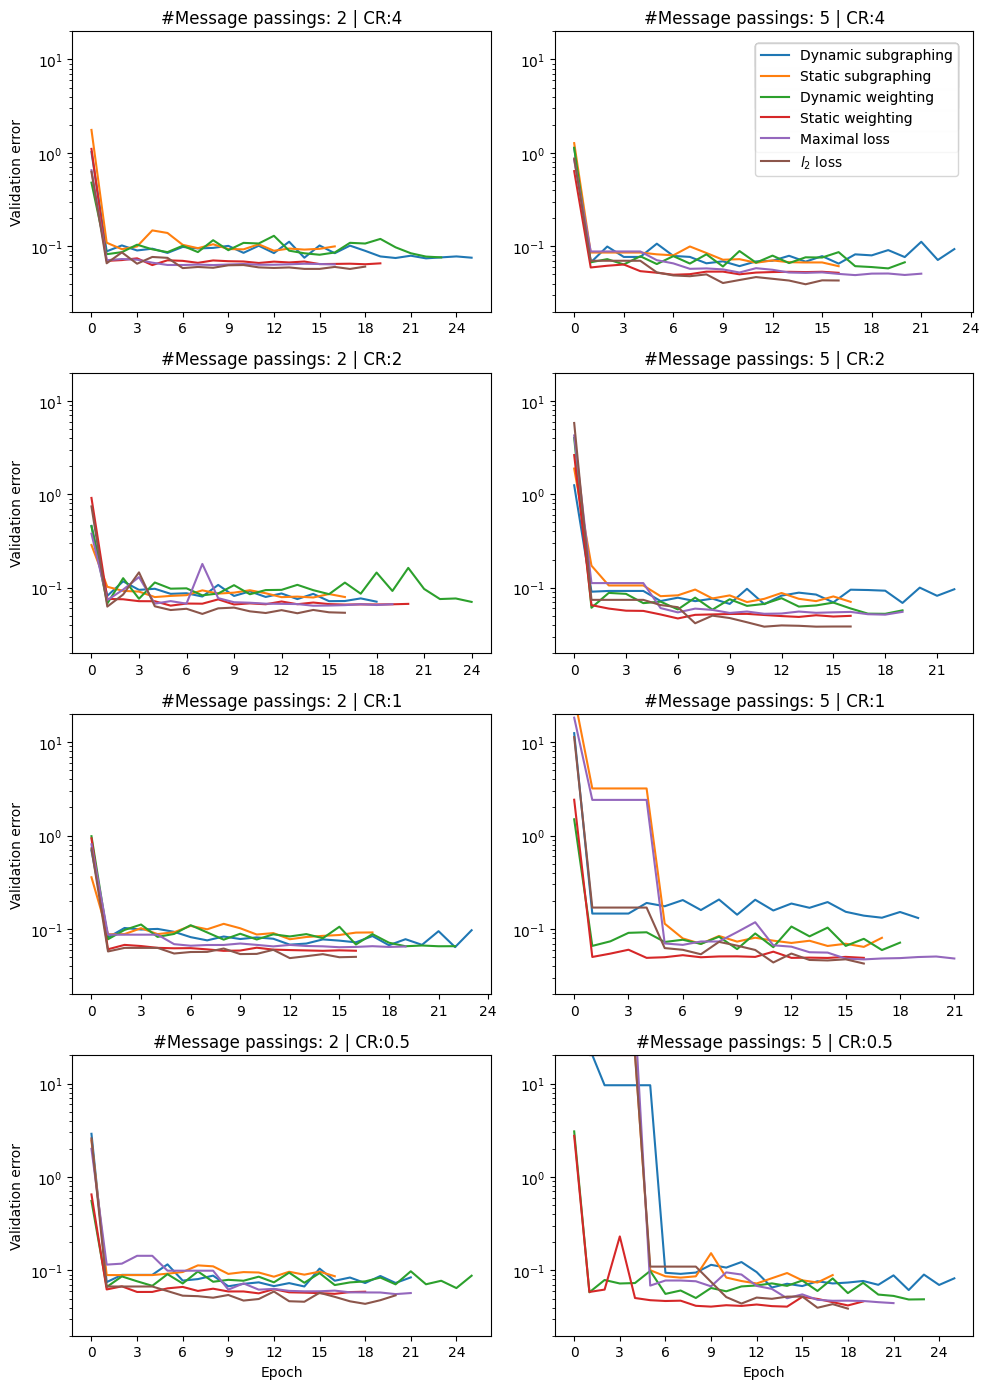

In [ ]:
plot('gnn')

In [ ]:
# loading the experiments
with open('experiment.json', 'r') as file:
    json_dict = json.load(file)
    compression_ratio = json_dict['compression_ratio']
    frame_length = json_dict['frame_length']
    num_message_passings = json_dict['num_message_passings']
    rotation = json_dict['rotation']
    maxK = json_dict['maxK']

In [ ]:
def compute_error(exp_num, loss_type_list, large_scale=True):

    if large_scale:
        model_dir = 'knee'
        graph_batch_size = {'test': 5, 'valid': 5, 'train': 5}
    else:
        model_dir = 'Simple_3D'
        graph_batch_size = {'test': 100, 'valid': 100, 'train': 100}

    modelTools = model_tools(
        frame_length=frame_length[exp_num],
        transformation=with_transform_stats,
        rotation = False,
        maxK=0.0,
        graph_batch_size = graph_batch_size,
        model_dir=model_dir,
        )

    modelTools.prepare_ds(num_message_passings=num_message_passings[exp_num])

    if large_scale:
        ds = modelTools.ds['train'].concatenate(modelTools.ds['valid']).concatenate(modelTools.ds['test'])
    else:
        ds = modelTools.ds['test']

    error = {}
    pmse = {}
    encoded_inputs = False
    for x, y in ds.take(1):
        for model_type in ['gnn', 'combined']:
            error_of_loss = {}
            pmse_of_loss = {}
            for loss_type in loss_type_list:
                modelTools.load_data(loss_type, exp_num, model_type)

                if model_type == 'combined' and encoded_inputs == False:
                    x['node_features'] = modelTools.encoder(x)[tf.newaxis]
                    encoded_inputs = True

                predict = modelTools.model(x).numpy()
                target = y.numpy()
                diff = (predict - target)
                error_of_loss[loss_type] = (diff**2).mean()
                pmse_of_loss[loss_type] = (diff**2).mean(axis=2)[0].tolist()

            pmse[model_type] = pmse_of_loss
            error[model_type] = error_of_loss

    return error, pmse

def get_df(exp_num):
    with_da, with_da_p = compute_error(exp_num, lst)
    with_da = pd.DataFrame(with_da)
    without_da, without_da_p = compute_error(exp_num+8, lst)
    without_da = pd.DataFrame(without_da)
    new_df = pd.concat([with_da, without_da], axis = 1)
    new_df.columns = pd.MultiIndex.from_arrays(
        [['With augmentation']*2 + ['Without augmentation']*2, ['With AE', 'Without AE']*2]
        )
    pmse_dict = {'With augmentation': with_da_p, 'Without augmentation': without_da_p}
    return new_df.round(2), pmse_dict

indeces = ['Dynamic subgraphing', 'Static subgraphing', 'Dynamic weighting',
           'Static weighting', 'Maximal loss', r'$\boldsymbol{l_2}$ loss']

In [ ]:
new_df, pmse_dict = {}, {}

for exp_num in range(1, 9):
    key = f"Compression ratio: {compression_ratio[exp_num]} and number of message passings: {num_message_passings[exp_num]}"
    new_df[key], pmse_dict[key] = get_df(exp_num)

In [ ]:
# now store the evaluation results for Abaqus plotting

with open(r'C:\Temp\DA\results.pkl', 'wb') as file:
    pickle.dump(pmse_dict, file, protocol=2)

In [ ]:
def fix_latex(latex):
    latex = latex[:14] + r'\centering' + '\n' + latex[14:]

    new_line = r'\multicolumn{2}{c}{\textbf{With augmentation}} & \multicolumn{2}{c}{\textbf{Without augmentation}}'
    idx_0 = latex.find(r'\multicolumn{2}{r}')
    idx_1 = latex.rfind('{Without augmentation}')+len('{Without augmentation}')
    latex = latex[:idx_0] + new_line + latex[idx_1:]

    idx = latex.rfind(r' & With AE & Without') - len(r' & With AE & Without AE')
    return latex[:idx] + r' \cmidrule{2-3} \cmidrule{4-5}' + '\n' + r'\textbf{Model type}'  + latex[idx:] + '\n'

latex_list = []
df_dict = {}

for key in new_df:
    df = new_df[key].copy()
    df.drop('top_1', inplace=True)
    df.index = indeces
    df_dict[key] = df

    caption = 'Out-of-distribution MSE of the full model used in chapter 5 with ' + key.lower()
    caption = "".join(caption.split(':')) + '.'
    label = "table_" + "_".join((key.split(" ")[2], key.split(" ")[-1], ))

    latex = df.round(2).to_latex(bold_rows=True, caption=caption,
        label=label, column_format='lcccc', float_format=lambda x: f"{x:.2f}")

    latex_list.append(fix_latex(latex))

print("".join(latex_list))


\begin{table}
\centering
\caption{Out-of-distribution MSE of the full model used in chapter 5 with compression ratio 4 and number of message passings 2.}
\label{table_4_2}
\begin{tabular}{lcccc}
\toprule
 & \multicolumn{2}{c}{\textbf{With augmentation}} & \multicolumn{2}{c}{\textbf{Without augmentation}} \\
 \cmidrule{2-3} \cmidrule{4-5}
\textbf{Model type} & With AE & Without AE & With AE & Without AE \\
\midrule
\textbf{Dynamic subgraphing} & 0.13 & 0.10 & 0.45 & 0.16 \\
\textbf{Static subgraphing} & 0.47 & 0.16 & 1.26 & 0.94 \\
\textbf{Dynamic weighting} & 0.09 & 0.19 & 0.43 & 14.83 \\
\textbf{Static weighting} & 0.12 & 0.67 & 0.55 & 0.99 \\
\textbf{Maximal loss} & 0.09 & 0.16 & 0.51 & 19.73 \\
\textbf{$\boldsymbol{l_2}$ loss} & 0.13 & 0.11 & 1.08 & 1.52 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}
\centering
\caption{Out-of-distribution MSE of the full model used in chapter 5 with compression ratio 4 and number of message passings 5.}
\label{table_4_5}
\begin{tabular}{lc

c:\ProgramData\Anaconda3\envs\py10\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\user\AppData\Local\Temp\ipykernel_41032\2241984579.py:22: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


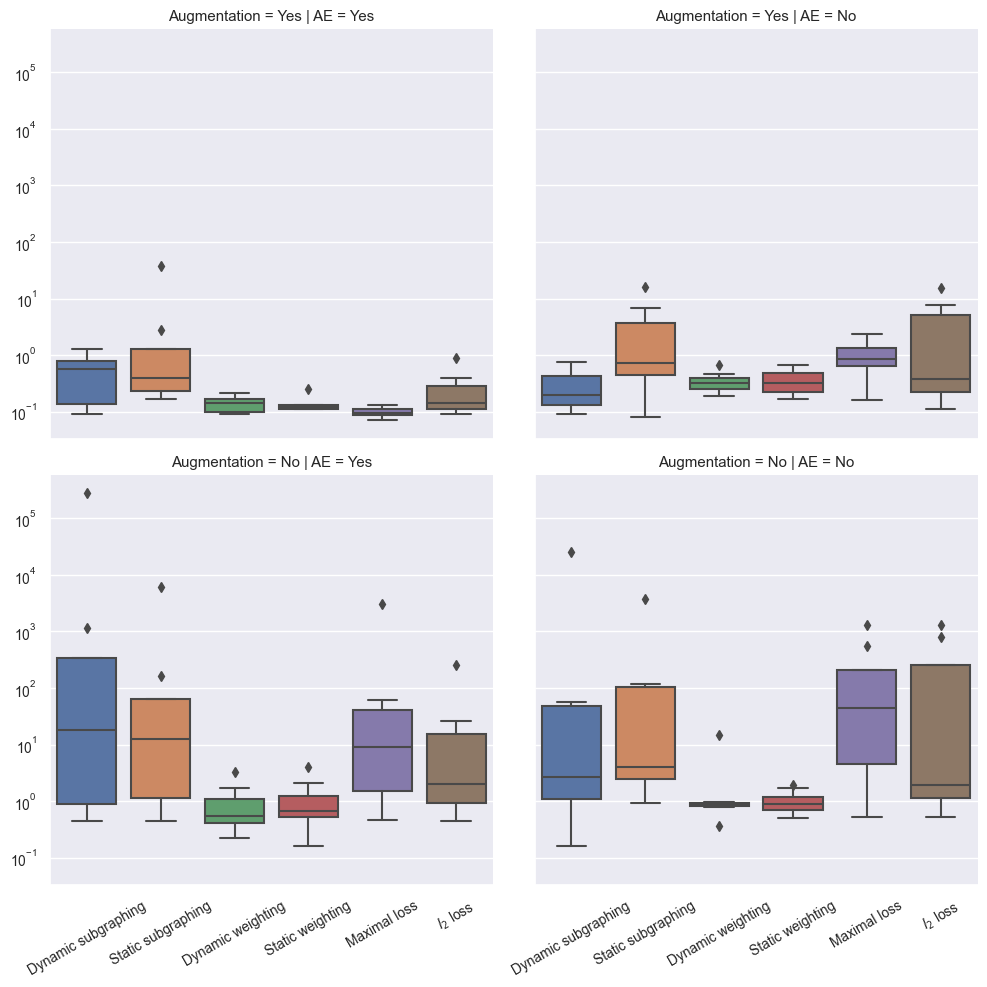

In [ ]:
df_list = [df.copy() for df in df_dict.values()]

df_after_loop = []

for df in df_list:
    df = df.transpose().reset_index()
    df.rename(columns={'level_0': 'Augmentation', 'level_1': 'AE'}, inplace=True)
    df_after_loop.append(df)

df = pd.concat(df_after_loop)
df = df.replace(
    {'With augmentation': 'Yes', 'Without augmentation': 'No',
     'With AE': 'Yes', 'Without AE': 'No',}
    )

df.rename(columns={r'$\boldsymbol{l_2}$ loss': '$l_2$ loss'}, inplace=True)

sns.set(font_scale=0.9)
g = sns.catplot(kind='box', data=df, col='AE', row='Augmentation')
plt.yscale('log')
g.tick_params(axis='x', rotation=30)
plt.tight_layout()
plt.savefig("3d_boxplot.pdf", format="pdf")

In [ ]:
def get_df(exp_list=[1, 3, 5, 7]):
    df_list = []
    for exp_num in exp_list:
        new_df, _ = compute_error(exp_num, lst, 1, large_scale=False)
        df = pd.DataFrame(new_df)
        key = f"Compression ratio: {compression_ratio[exp_num]}"
        df.columns = pd.MultiIndex.from_tuples([
            (key, 'gnn'),
            (key, 'combined'),
            ])
        df_list.append(df)
    return pd.concat(df_list, axis = 1).round(2)

In [ ]:
df_2 = get_df()

In [ ]:
df_5 = get_df([2, 4, 6, 8])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
df = df_2.copy()
df.drop('top_1', inplace=True)
df.index = indeces
df

Compression ratio: 4          Compression ratio: 2  \
                                         gnn combined                  gnn   
Dynamic subgraphing                     0.08     0.13                 0.11   
Static subgraphing                      0.15     0.17                 0.09   
Dynamic weighting                       0.09     0.27                 0.07   
Static weighting                        0.08     0.21                 0.06   
Maximal loss                            0.08     0.17                 0.07   
$\boldsymbol{l_2}$ loss                 0.07     0.13                 0.08   

                                 Compression ratio: 1           \
                        combined                  gnn combined   
Dynamic subgraphing         0.08                 0.07     0.07   
Static subgraphing          0.25                 0.10     0.15   
Dynamic weighting           0.19                 0.08     0.40   
Static weighting            0.31                 0.07     0.41   
Maximal loss                1.10                 0.08     0.76   
$\boldsymbol{l_2}$ loss     0.20                 0.08     0.18   

                        Compression ratio: 0.5           
                                           gnn combined  
Dynamic subgraphing                       0.07     0.08  
Static subgraphing                        0.10     0.99  
Dynamic weighting                         0.07     0.53  
Static weighting                          0.07     0.34  
Maximal loss                              0.08     1.44  
$\boldsymbol{l_2}$ loss                   0.05     0.34

In [ ]:
latex = df.to_latex(
    bold_rows=True,
    float_format=lambda x: f"{x:.2f}",
    caption='In-distribution MSE of the small-scale model used in chapter 5 with message passings: 2.',
    label="table_in_distribution_2",
    column_format='lcccc',
    )

latex = latex[:14] + r'\centering' + '\n' + latex[14:]
print(latex)

\begin{table}
\caption{In-distribution MSE of the small-scale model used in chapter 5 with message passings: 2.}
\label{table_in_distribution_2}
\begin{tabular}{lcccc}
\toprule
 & \multicolumn{2}{r}{Compression ratio: 4} & \multicolumn{2}{r}{Compression ratio: 2} & \multicolumn{2}{r}{Compression ratio: 1} & \multicolumn{2}{r}{Compression ratio: 0.5} \\
 & gnn & combined & gnn & combined & gnn & combined & gnn & combined \\
\midrule
\textbf{Dynamic subgraphing} & 0.08 & 0.13 & 0.11 & 0.08 & 0.07 & 0.07 & 0.07 & 0.08 \\
\textbf{Static subgraphing} & 0.15 & 0.17 & 0.09 & 0.25 & 0.10 & 0.15 & 0.10 & 0.99 \\
\textbf{Dynamic weighting} & 0.09 & 0.27 & 0.07 & 0.19 & 0.08 & 0.40 & 0.07 & 0.53 \\
\textbf{Static weighting} & 0.08 & 0.21 & 0.06 & 0.31 & 0.07 & 0.41 & 0.07 & 0.34 \\
\textbf{Maximal loss} & 0.08 & 0.17 & 0.07 & 1.10 & 0.08 & 0.76 & 0.08 & 1.44 \\
\textbf{$\boldsymbol{l_2}$ loss} & 0.07 & 0.13 & 0.08 & 0.20 & 0.08 & 0.18 & 0.05 & 0.34 \\
\bottomrule
\end{tabular}
\end{table}



In [ ]:
# Similarly
df = df_5.copy()
df.drop('top_1', inplace=True)
df.index = indeces
print(df.to_latex(bold_rows=True, float_format=lambda x: f"{x:.2f}",))

\begin{tabular}{lrrrrrrrr}
\toprule
 & \multicolumn{2}{r}{Compression ratio: 4} & \multicolumn{2}{r}{Compression ratio: 2} & \multicolumn{2}{r}{Compression ratio: 1} & \multicolumn{2}{r}{Compression ratio: 0.5} \\
 & gnn & combined & gnn & combined & gnn & combined & gnn & combined \\
\midrule
\textbf{Dynamic subgraphing} & 0.06 & 0.10 & 0.08 & 0.09 & 0.17 & 0.06 & 0.10 & 0.07 \\
\textbf{Static subgraphing} & 0.10 & 0.41 & 0.10 & 0.30 & 0.09 & 0.28 & 0.10 & 1.11 \\
\textbf{Dynamic weighting} & 0.09 & 0.26 & 0.07 & 0.30 & 0.07 & 0.22 & 0.08 & 0.23 \\
\textbf{Static weighting} & 0.08 & 0.20 & 0.08 & 0.32 & 0.08 & 0.16 & 0.07 & 0.19 \\
\textbf{Maximal loss} & 0.06 & 1.80 & 0.06 & 0.33 & 0.07 & 7.48 & 0.07 & 1.10 \\
\textbf{$\boldsymbol{l_2}$ loss} & 0.06 & 0.36 & 0.09 & 0.16 & 0.08 & 26.07 & 0.07 & 0.19 \\
\bottomrule
\end{tabular}



In [ ]:
# now getting the runtimes:

def get_time_data(model = 'Simple_3D'):
    hf = pd.read_csv(os.path.join('gnn_datasets', model, 'time_hf.csv'), header=None)
    lf = pd.read_csv(os.path.join('gnn_datasets', model, 'time_lf.csv'), header=None)
    df = pd.concat([hf, lf], axis=1)
    df.index = pd.RangeIndex(start=1, stop=hf.shape[0] + 1, step=1)

    df.columns = ['HF model', 'LF model']
    df_raw = df.copy()

    df['HF model'] = df['HF model'].astype(int)
    df['LF model'] = df['LF model'].astype(int)
    df['HF model_m'] = df['HF model'] // 60
    df['HF model_s'] = df['HF model'] % 60
    df['LF model_m'] = df['LF model'] // 60
    df['LF model_s'] = df['LF model'] % 60
    df.drop(['HF model', 'LF model'], axis=1, inplace=True)

    df = df[['LF model_m', 'LF model_s', 'HF model_m', 'HF model_s']]
    df.columns = pd.MultiIndex.from_tuples([
        ('HF model', 'Min'),
        ('HF model', 'Sec'),
        ('LF model', 'Min'),
        ('LF model', 'Sec')
        ])

    df = df.reset_index().rename(columns={'index': 'Small-scale sample'})
    df.set_index('Small-scale sample', inplace=True)
    print(df.to_latex())
    return df, df_raw

In [ ]:
_, df_raw = get_time_data()
df = df_raw/60
df_small = df.mean().round(2).astype(str) + " ± " + df.std().round(2).astype(str)

_, df_raw = get_time_data('knee')
df = df_raw/60
df_large = df.mean().round(2).astype(str) + " ± " + df.std().round(2).astype(str)
df_small.name = 'Small-scale simulation'
df_large.name = 'Large-scale simulation'
df = pd.concat([df_small, df_large], axis=1)

\begin{tabular}{lrrrr}
\toprule
 & \multicolumn{2}{r}{HF model} & \multicolumn{2}{r}{LF model} \\
 & Min & Sec & Min & Sec \\
Small-scale sample &  &  &  &  \\
\midrule
1 & 1 & 1 & 21 & 29 \\
2 & 1 & 16 & 18 & 54 \\
3 & 0 & 56 & 21 & 53 \\
4 & 0 & 48 & 19 & 54 \\
5 & 3 & 56 & 19 & 51 \\
6 & 1 & 1 & 20 & 0 \\
7 & 0 & 56 & 23 & 4 \\
8 & 1 & 36 & 18 & 7 \\
9 & 1 & 31 & 16 & 44 \\
10 & 0 & 51 & 16 & 7 \\
11 & 0 & 46 & 19 & 39 \\
12 & 0 & 52 & 21 & 13 \\
13 & 1 & 21 & 19 & 38 \\
14 & 1 & 6 & 18 & 16 \\
15 & 2 & 46 & 22 & 21 \\
16 & 1 & 21 & 19 & 19 \\
17 & 1 & 31 & 19 & 53 \\
18 & 0 & 56 & 21 & 22 \\
19 & 0 & 51 & 20 & 13 \\
20 & 0 & 46 & 23 & 6 \\
21 & 0 & 52 & 22 & 27 \\
22 & 1 & 6 & 20 & 43 \\
23 & 1 & 32 & 18 & 10 \\
24 & 1 & 21 & 19 & 0 \\
25 & 1 & 6 & 22 & 52 \\
26 & 1 & 42 & 24 & 10 \\
27 & 4 & 12 & 19 & 10 \\
28 & 1 & 22 & 20 & 45 \\
29 & 0 & 46 & 21 & 20 \\
30 & 1 & 26 & 24 & 3 \\
31 & 2 & 1 & 21 & 32 \\
32 & 1 & 12 & 21 & 45 \\
33 & 1 & 41 & 21 & 41 \\
34 & 1 & 6 & 27 & 0 \\
35 & 

In [ ]:
print(df.to_latex(
    caption='Runtimes (Min) with their mean and standard deviation for each model.',
    label='tabel:runtimes_stats'
    ))

\begin{table}
\caption{Runtimes (Min) with their mean and standard deviation for each model.}
\label{tabel:runtimes_stats}
\begin{tabular}{lll}
\toprule
 & Small-scale simulation & Large-scale simulation \\
\midrule
HF model & 21.21 ± 2.16 & 118.31 ± 6.42 \\
LF model & 1.31 ± 0.69 & 3.07 ± 0.27 \\
\bottomrule
\end{tabular}
\end{table}



In [ ]:
def plot_augmented_graph(maxK=0.0, rotation=False, component=0):

    modelTools = model_tools(
        frame_length=2,
        transformation=with_transform_stats,
        rotation = rotation,
        maxK=maxK,
        graph_batch_size = {'test': 1, 'valid': 1, 'train': 1},
        model_dir='Simple_3D',
        return_nodal_pos = True,
        )

    modelTools.prepare_ds(num_message_passings=1)

    for sample in modelTools.ds['train_sample'].take(1): pass

    node_colors = sample['node_features'][:, component].numpy()
    norm = plt.Normalize(node_colors.min(), node_colors.max())

    nodal_pos = sample['nodal_pos'].numpy()
    senders = sample['senders'].numpy()
    receivers = sample['receivers'].numpy()

    centroid = np.mean(nodal_pos, axis=0)
    d = 4

    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')
    ax.axis('off')

    sc = ax.scatter(nodal_pos[:, 0], nodal_pos[:, 1], nodal_pos[:, 2],
                    c=node_colors, marker='o', s=100, cmap='viridis', norm=norm)

    for s, r in zip(senders, receivers):
        start_point = nodal_pos[s]
        end_point = nodal_pos[r]
        ax.plot([start_point[0], end_point[0]],
                [start_point[1], end_point[1]],
                [start_point[2], end_point[2]], 'b-', lw=3, alpha=0.1)

    ax.set_xlim([centroid[0] - d, centroid[0] + d])
    ax.set_ylim([centroid[1] - d, centroid[1] + d])
    ax.set_zlim([centroid[2] - d, centroid[2] + d])

    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.grid(False)
    plt.savefig(str(maxK)+'.png', dpi=300)
    return ax


<Axes3D: >

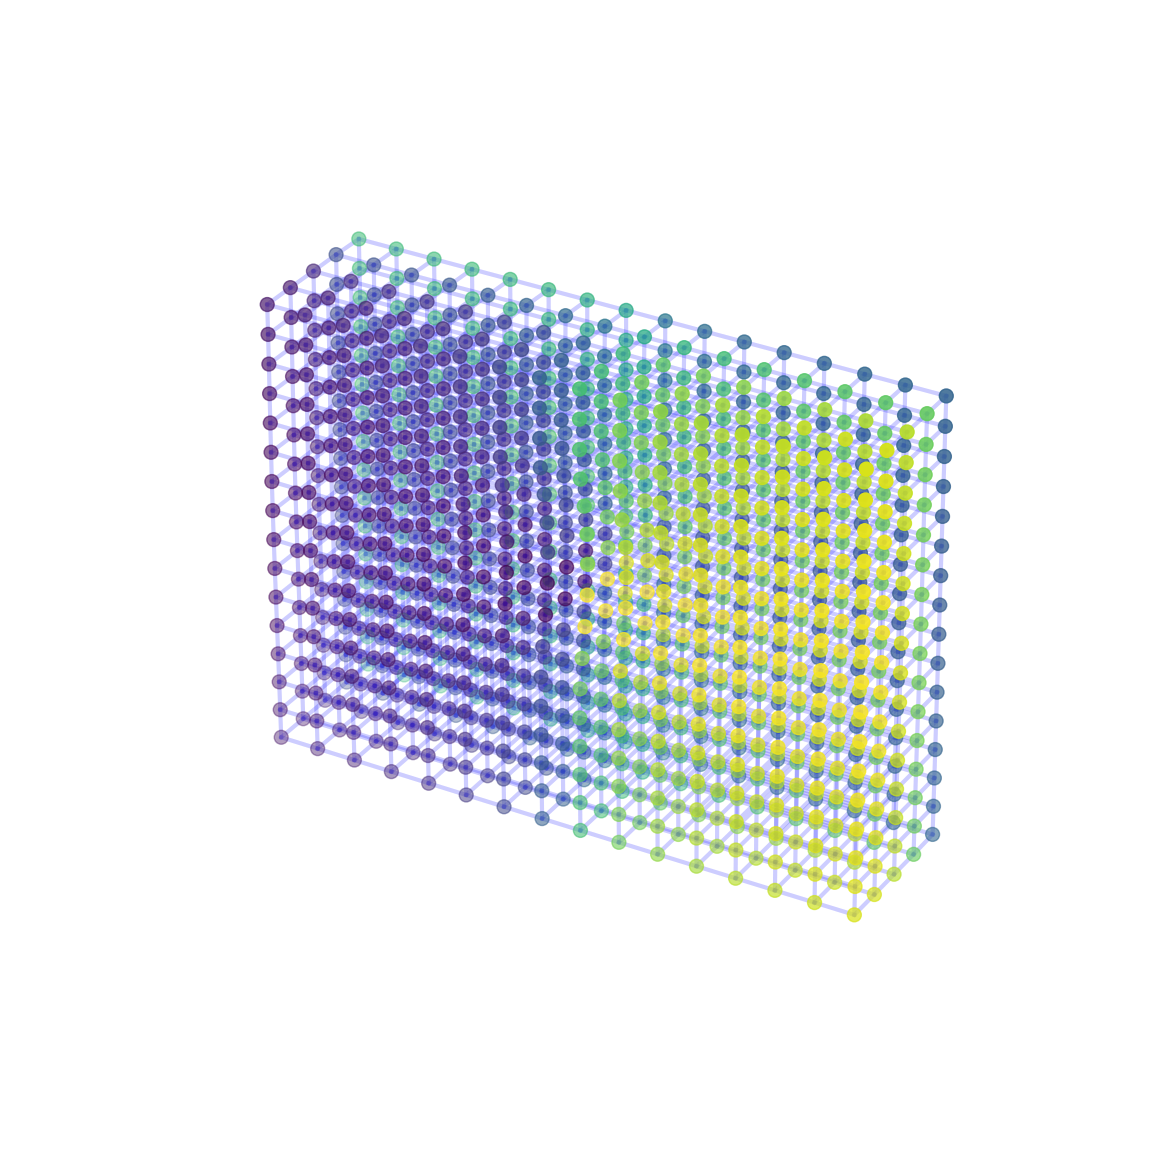

In [ ]:
plot_augmented_graph()

<Axes3D: >

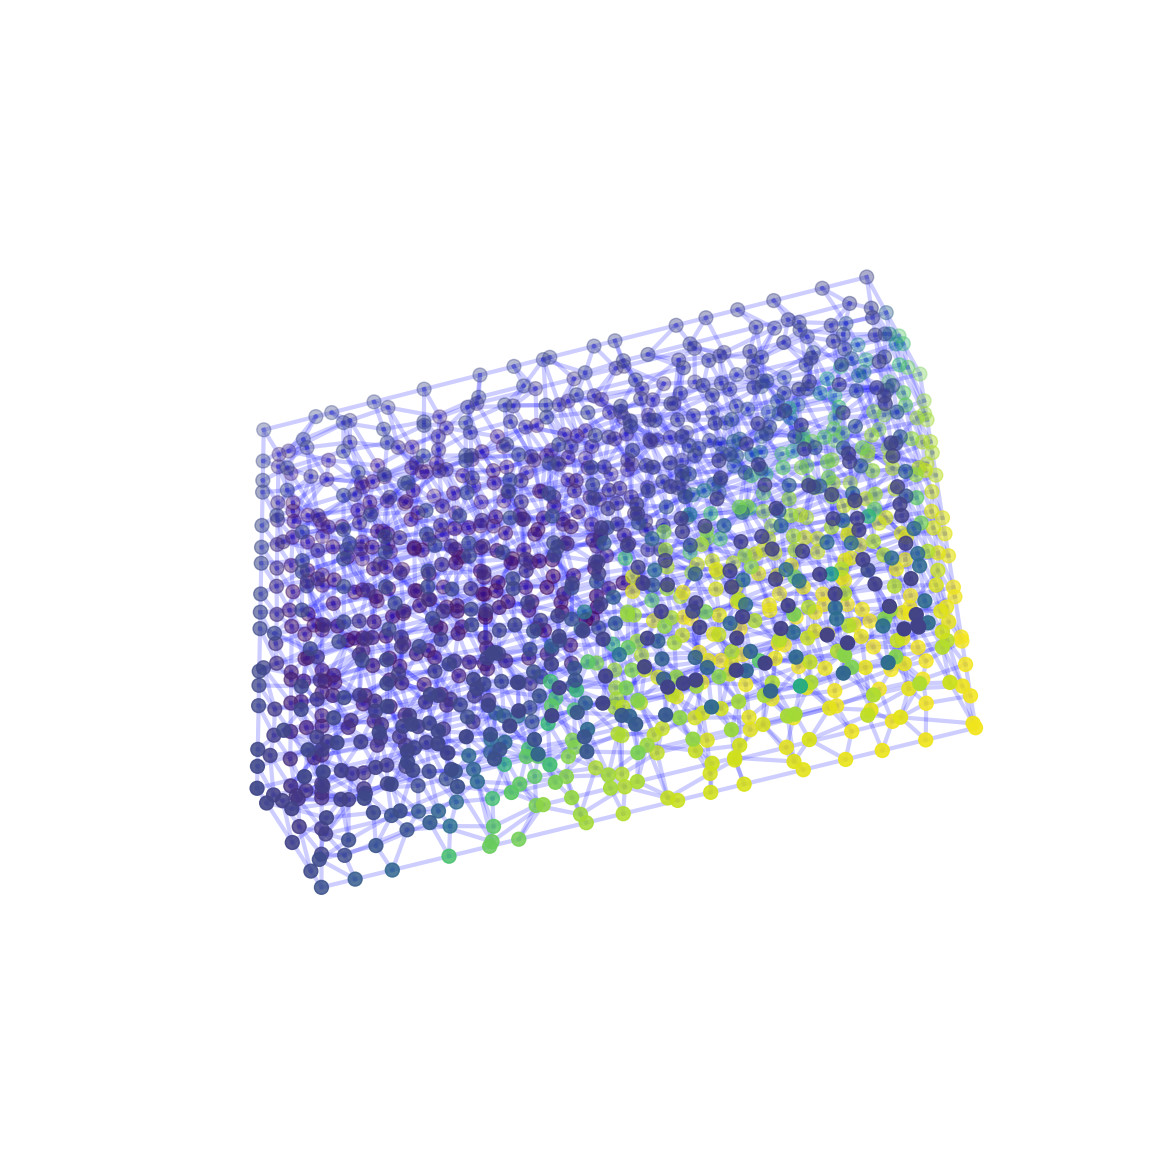

In [ ]:
plot_augmented_graph(maxK=1.0, rotation=True)